# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

импортируем нужные библиотеки

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

открываем файлы, сохраняем их в переменные и просматриваем данные

In [2]:
df = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
def data_analis (df):
    i=df.info()
    h=df.head()
    ds=df.describe()
    dp=df.duplicated().sum()
    return print(i),print(h), print(ds), print('дубликаты:',dp)

In [4]:
data_analis(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      4

(None, None, None, None)

In [5]:
data_analis(df_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.7

(None, None, None, None)

In [6]:
data_analis(df_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      4

(None, None, None, None)

В данных отсутсвуют пропуски, что просто замечательно, меньше возни. Удалим из каждого датафрейма столбец id. Он не важен для модели.

In [7]:
df = df.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

Построим гистограммы по столбцу product.

In [8]:
# Построим гистограммы по столбцу product.
def hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    plt.hist(seria, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

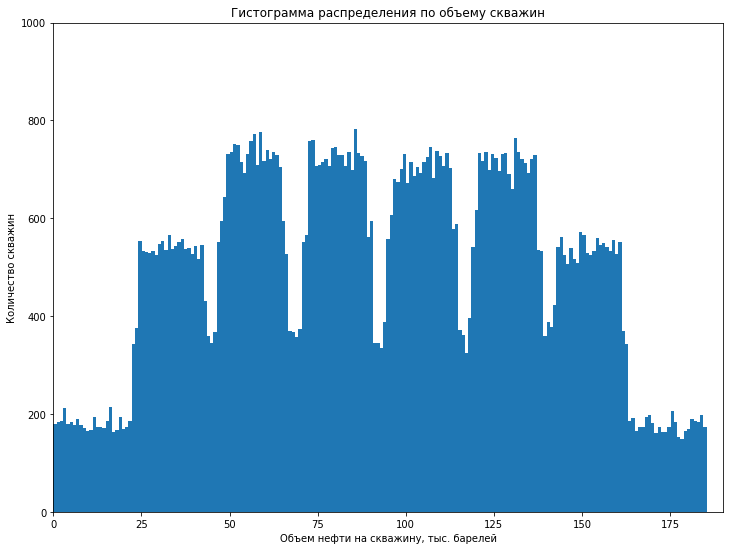

In [9]:
hist(df['product'], 200, 190, 1000)

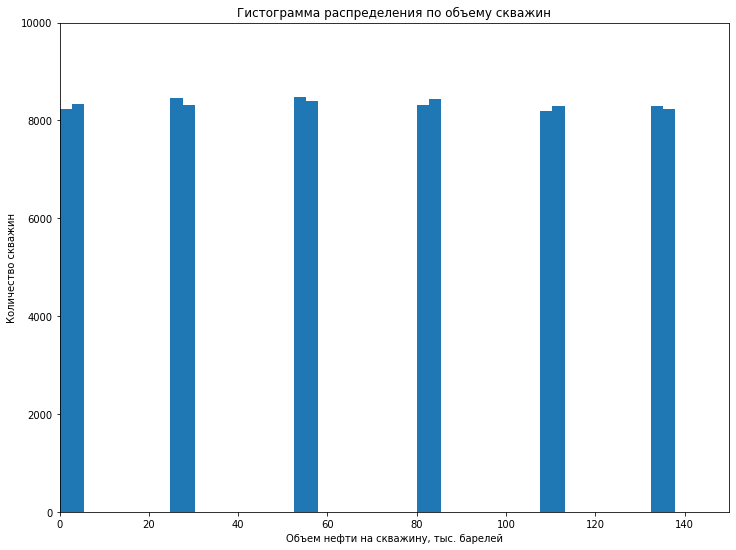

In [10]:
hist(df_1['product'], 50, 150, 10000)

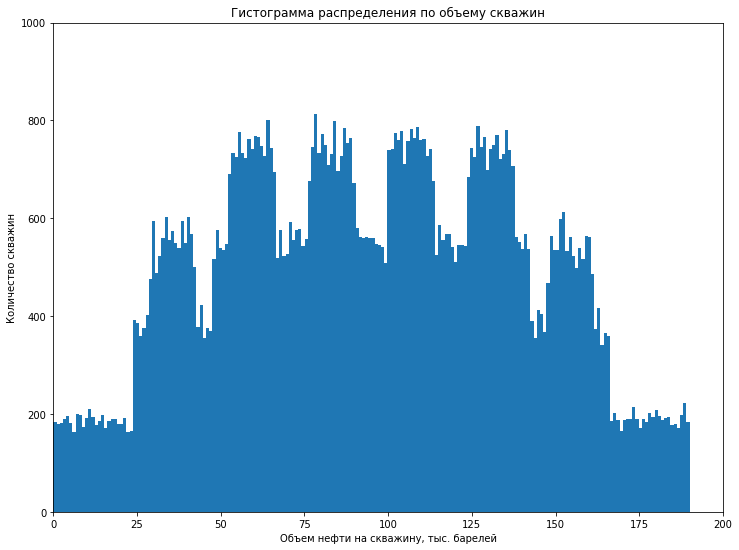

In [11]:
hist(df_2['product'], 200, 200, 1000)

построим диаграммы рассеяния

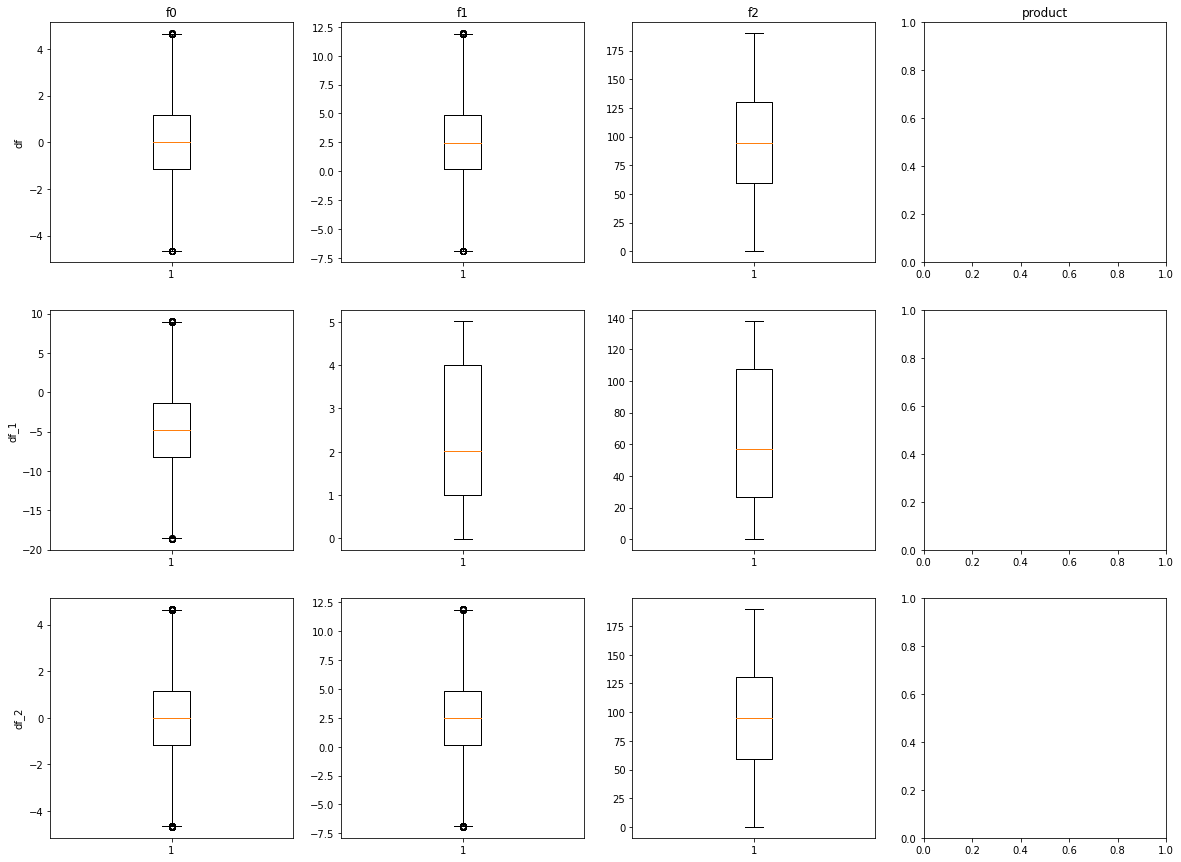

In [90]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["df","df_1","df_2"]
num_columns = df.columns[0:]
num_columns_with_columns = zip(df.columns[0:],range(4))
all_frames_with_rows = zip([df,df_1,df_2],range(3))

for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])

for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])

for column in range(4):
    ax[0][column].set_title(num_columns[column])

вывод: в некоторых столбцах есть данные, выходящие за границы. Эти данные будут мешать модели обучаться, отвлекая её. Поэтому их необходимо удалить.

создадим функцию для удаления подобных данных

In [16]:
def remove_ouliers(df,column):
    q25=np.array(df[column].quantile(0.25))
    
    q75=np.array(df[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(df[column].index,df[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

применим ее

In [17]:
noise_data = [(df,"f2"),
 (df_1,"f1"),
 (df_2,"f0"),
 (df_2,"f1"),
 (df_2,"f2")]

for df,column in noise_data:
    indexes = remove_ouliers(df,column)
    df.drop(indexes,axis = 0,inplace = True)

Количество строк, выбранных для удаления:  506
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  733
Количество строк, выбранных для удаления:  682
Количество строк, выбранных для удаления:  582


In [18]:
df = df.reset_index(drop = True)
df_1 = df_1.reset_index(drop = True)
df_2 = df_2.reset_index(drop = True)

еще раз построим диагармму рассеяния 

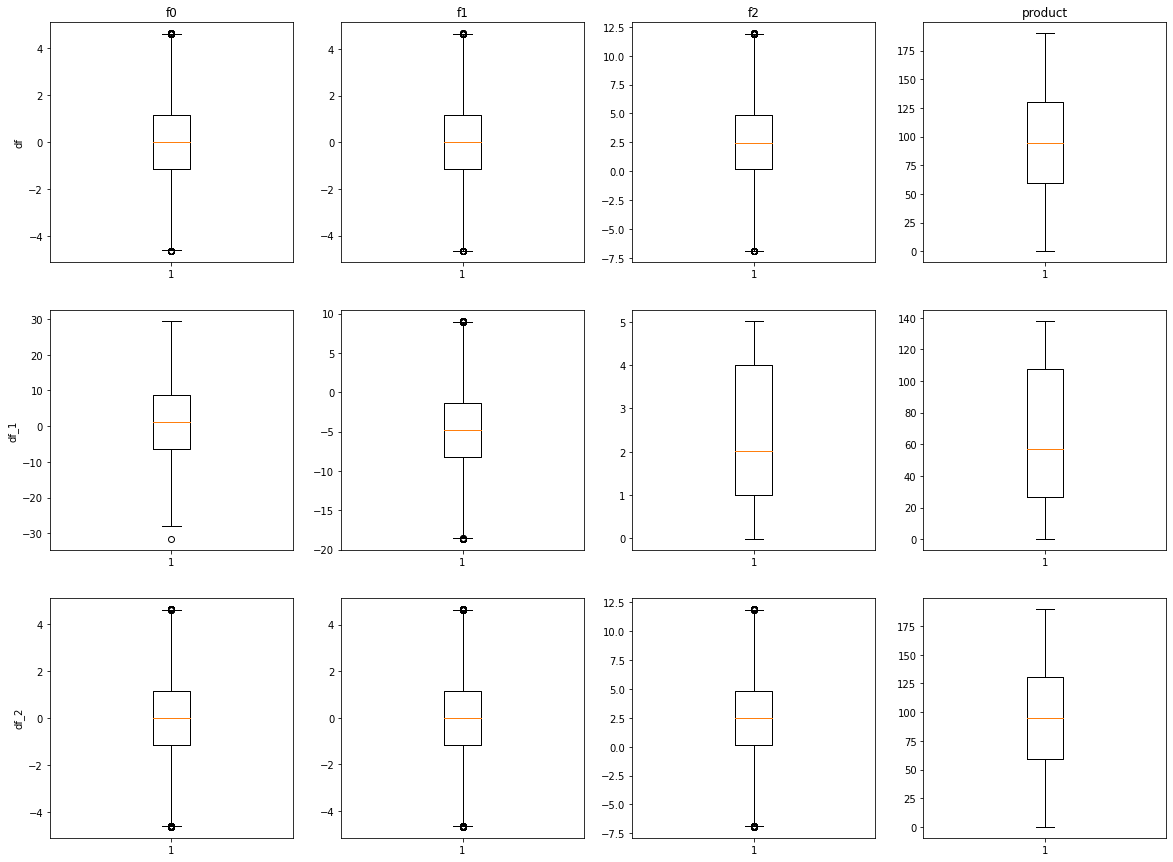

In [91]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["df","df_1","df_2"]
num_columns = df.columns[0:]
num_columns_with_columns = zip(df.columns[0:],range(4))
all_frames_with_rows = zip([df,df_1,df_2],range(3))

for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])

for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])

for column in range(4):
    ax[0][column].set_title(num_columns[column])

вывод: в вывод, видим что почти все данные выходящие за пределы нормали ушли, это значительно повысет качество модели

посмотрим количество пропусков в данных для столбца 'product', особено инетересен df_1, т.к. в нем присутствует множество пропусков в даном столбце

In [20]:
def check_zeros(df, target_name):
    zeros = df[df[target_name] == 0][target_name].count()
    percent = zeros / df.shape[0]
    print('Количество нулевых значений -', zeros)
    print('Процент нулевых значений -', percent)

In [21]:
print(check_zeros(df, 'product'),sep='')
print(check_zeros(df_1, 'product'),sep='')
print(check_zeros(df_2, 'product'),sep='')

Количество нулевых значений - 1
Процент нулевых значений - 1.0203769272369213e-05
None
Количество нулевых значений - 8173
Процент нулевых значений - 0.08225312990620345
None
Количество нулевых значений - 1
Процент нулевых значений - 1.0203769272369213e-05
None


вывод: Во втором датафрейме около 8,2% месторождений не имело значения в столбце product. При сравнении с такими же значениями из первого и третьего датафрейма можно понять, что были утеряны данные или не они не были исследованы.

По гистограммам можно понять, что у первого и третьего фрейма распределение скважин близкое к нормальному. Во втором датафрейме данные имеют странное распределение: от 0 до 5 баррелей с шагом по 15-20 равномерно распределены 100000 значений. Данные не подчиняются закону больших чисел и скорей всего были введены искуственно.

Также данные были подготовленны к делению на выборки, для дальнейшего обучения модели.

## Обучение и проверка модели

т.к. работаем сразу с 3 дата фреймами проще всего будет создать функцию для разбивки фреймов на выборки.

Произведем вывод предсказанного запаса с реальным и выведем RMSE. Для этого напишем функцию.

In [46]:

model = LinearRegression()

def predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)


    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [47]:
df_predicted, df_rmse, df_predicted_mean, df_predicted_sum = predict(df, 'product')
print(df_predicted.head())
print('RMSE -', df_rmse)
print('Средний запас запасанного сырья -', df_predicted_mean)

       real_product  predicted_product
33309    118.102692          88.674397
24660    138.922937         101.446221
644       80.090879          67.964319
40155     63.871875          69.315998
40706     91.091936          72.246904
RMSE - 40.17679711012713
Средний запас запасанного сырья - 94.67716913212334


In [48]:
df_1_predicted, df_1_rmse, df_1_predicted_mean, df_1_predicted_sum = predict(df_1, 'product')
print(df_1_predicted.head())
print('RMSE -', df_1_rmse)
print('Средний запас запасанного сырья -', df_1_predicted_mean)

       real_product  predicted_product
82769      3.179103           3.259301
60916    110.992147         111.017480
33596      3.179103           2.797422
95799     80.859783          82.993957
63600     57.085625          57.153420
RMSE - 0.88944781464016
Средний запас запасанного сырья - 68.59166978153502


In [49]:
df_2_predicted, df_2_rmse, df_2_predicted_mean, df_2_predicted_sum = predict(df_2, 'product')
print(df_2_predicted.head())
print('RMSE -', df_2_rmse)
print('Средний запас запасанного сырья -', df_2_predicted_mean)

       real_product  predicted_product
33309    118.102692          88.674397
24660    138.922937         101.446221
644       80.090879          67.964319
40155     63.871875          69.315998
40706     91.091936          72.246904
RMSE - 40.17679711012713
Средний запас запасанного сырья - 94.67716913212334


Оценим общий запас на регион по предсказанным данным

In [50]:
print('Суммарный предсказанный запас в позиции 0 -', df_predicted_sum)
print('Суммарный реальный запас в позиции 0 -', df_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 1 -', df_1_predicted_sum)
print('Суммарный реальный запас в позиции 1 -', df_1_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 2 -', df_2_predicted_sum)
print('Суммарный реальный запас в позиции 2 -', df_2_predicted['real_product'].sum())

Суммарный предсказанный запас в позиции 0 - 2319685.320906154
Суммарный реальный запас в позиции 0 - 2322658.4866408696

Суммарный предсказанный запас в позиции 1 - 1703885.6690431114
Суммарный реальный запас в позиции 1 - 1703921.4421404235

Суммарный предсказанный запас в позиции 2 - 2319685.320906154
Суммарный реальный запас в позиции 2 - 2322658.4866408696


Вывод: Данные предсказаний о количестве нефти по сумме примерно совпадают по сумме с предсказанными значениями. Лучше всего модель предсказала запасы во втором фрейме (RMSE - 0.88), далее в первом и третьем соотвественно.

Возможно утеряные данные из второго фрейма сказались на модели и она достаточно сильно переобучилась.

Но из-за утери данных и малого запаса в среднем не имеет смысла рассматривать второй фрейм как прибыльное месторождение.

Изучим все фреймы на риски и прибыль, но в конечном итоге будем выбирать между 1 и 3 фреймом.

## Подготовка к расчёту прибыли

Создадим переменные об экономической информации.

In [51]:
budget = 10*(10**9) #10 000 000 000
print(budget)
chosen_points = 500 #исследуем 500 точек
best_points = 200 #200 лучших
price_per_barrel = 450000 #за 1000 баррель

10000000000


Расчитаем безубыточную разработку сырья на 200 месторождениях. И найдем среднее количество продукта в месторождениях необходимое для этого.

In [26]:
average_profit_per_point = budget / best_points
print('Средняя прибыль на лучшую точку -', average_profit_per_point, 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / price_per_barrel
print('Средний объем нефти на точку -',average_barrels_per_point, 'тыс. баррелей')

average_barrels = budget / price_per_barrel
print('Средний объем нефти на регион -',average_barrels, 'тыс. баррелей')

Средняя прибыль на лучшую точку - 50000000.0 тыс.руб.
Средний объем нефти на точку - 111.11111111111111 тыс. баррелей
Средний объем нефти на регион - 22222.222222222223 тыс. баррелей


Фактические запасы

In [27]:
print('Средний запас фактичекой нефти на скважину в 1', df['product'].mean())
print('Средний запас фактичекой нефти на скважину в 2', df_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в 3', df_2['product'].mean())

Средний запас фактичекой нефти на скважину в 1 92.50000000000001
Средний запас фактичекой нефти на скважину в 2 68.82500000000002
Средний запас фактичекой нефти на скважину в 3 95.00000000000004


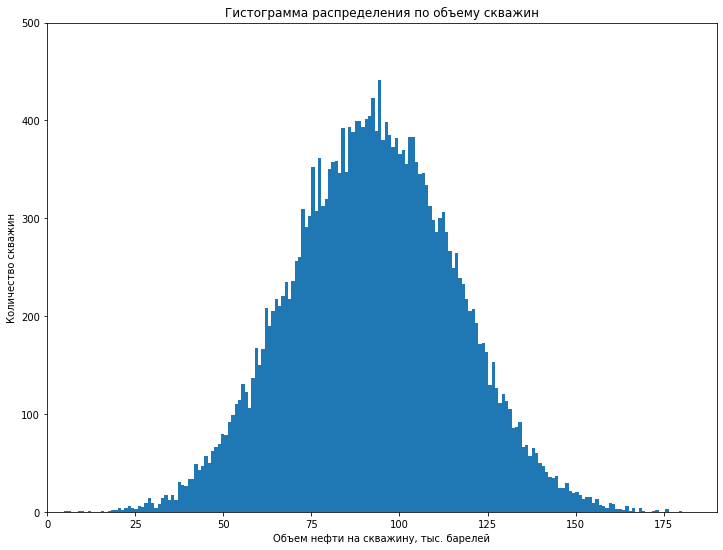

In [28]:
hist(df_predicted['predicted_product'], 200, 190, 500)

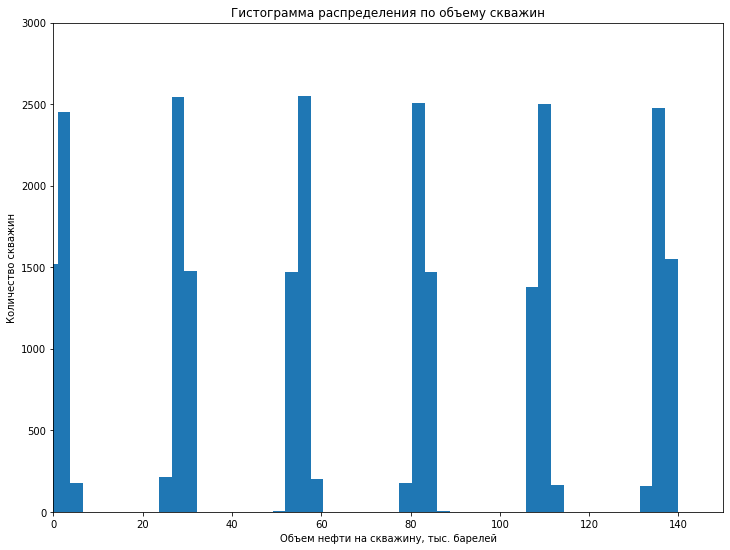

In [29]:
hist(df_1_predicted['predicted_product'], 50, 150, 3000)

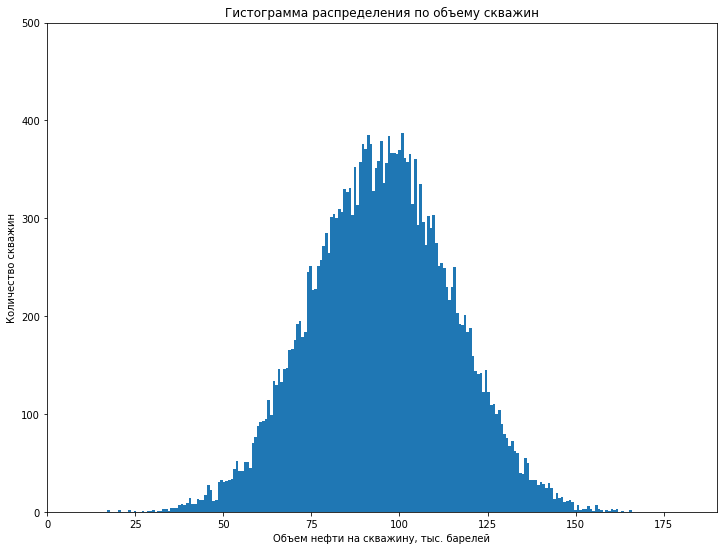

In [30]:
hist(df_2_predicted['predicted_product'], 200, 190, 500)

Вывод: Анализ средних объемов на скважину для каждого региона следующий.

Средний запас фактичекой нефти на скважину в 1 92.50000000000001
Средний запас фактичекой нефти на скважину в 2 68.82500000000002
Средний запас фактичекой нефти на скважину в 3 95.00000000000004
Изучены средние фактические запасы. Для первого и третьего - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.5 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого среднего.

Во вторых данных может быть и есть определенный смысл - значений больше 111 достаточно много и при определенной доли везения можно выбрать только лучшие в этой выборке, хотя и среднее значение 68.8.

## Расчёт прибыли и рисков 

Функция для расчета прибыли на 500 разведанных точек.

In [61]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return price_per_barrel * selected.sum() - budget

Функция Bootstrap с 1000 выборок

In [72]:
state = np.random.RandomState(1515)
def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=chosen_points)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, best_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [84]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(df_predicted['real_product'], 
                                                     df_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по первому региону.
Средняя прибыль по региону = 348125731.47 тыс.руб.
95% доверительный интервал от -210000061.88 до 845936416.52 тыс.руб.
Процент риска 9.60%


In [85]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(df_1_predicted['real_product'], 
                                                     df_1_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по первому региону.
Средняя прибыль по региону = 455809928.22 тыс.руб.
95% доверительный интервал от 18962524.26 до 877995089.91 тыс.руб.
Процент риска 2.00%


In [86]:
average_3, lower_3, upper_3, risk_3 = bootstrap_1000(df_2_predicted['real_product'], 
                                                     df_2_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_3))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_3, upper_3))
print('Процент риска {:.2%}'.format(risk_3))

Данные по первому региону.
Средняя прибыль по региону = 359019731.21 тыс.руб.
95% доверительный интервал от -153043652.58 до 875157252.87 тыс.руб.
Процент риска 9.40%


Вывод:Мы отсеиваем первый и третий регион, так как риски относительно велики (10,5% и 10%). Остается один единственный - второй, чей риск ниже требуемого (1.7%). Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится.

## Вывод

Итоговый вывод:

Изучины данные. Проведена подготовка данных к моделированию, были проведены проверка на дубликаты,пропущенные значения и корреляции признаков.

Обучена модель для каждого дата фрейма (региона) df, df_1, df_2.

Составлена функция расчета прибыли в регионе.

Посчитана прибыль и риски за каждый регион и обоснован выбор региона.

Второй регион получился одним из лучших по показателям предсказывания, хотя данные не выглядят нормально распределенными. Что довольно не обычно для подобного рода данных.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован